In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import FinanceDataReader as fdr
from sklearn import neighbors,svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import FinanceDataReader as fdr
import mglearn
from sklearn.preprocessing import MinMaxScaler
import sklearn

#성과 평가
from sklearn.metrics import confusion_matrix #오차행렬
from sklearn.metrics import accuracy_score #정확도


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_10=df["Close"].rolling(10).mean()
    MA_60=df["Close"].rolling(60).mean()
    df=df.assign(MA_10=MA_10,MA_60=MA_60).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df

In [4]:
#이중 분류
#외삽 풀리는 KS11(코스피) KQ11(코스닥) SSEC(상해) HSCE(홍콩) RTSI(러시아)
KS=fdr.DataReader("KS11","2009-01-01","2019-08-14")
time=np.linspace(0,10,len(KS),endpoint=False).reshape(-1,1)

#특성 추가---
KS=get_MA(KS)
KS=get_stochastic(KS)
#--------


# 이중 분류, 미래 예측을 위한 시간조정 ------------------- 
X=pd.DataFrame(KS)
y=pd.DataFrame(np.where(X.Change>=0,1,0),index=X.index).shift(-1).dropna()
X=X.loc[y.index]
#----------------------------

#전체 스케일 조정 ----------
minMaxScaler = MinMaxScaler().fit(X) 
X_scaler= minMaxScaler.transform(X)
X=pd.DataFrame(X_scaler,index=y.index,columns=X.columns)
#-----------------------------

X_train,X_test,y_train,y_test=X[:2000],X[2000:],y[:2000],y[2000:]

In [5]:
y


,0
Date,
2009-03-30,1.0
2009-03-31,1.0
2009-04-01,1.0
2009-04-02,1.0
2009-04-03,1.0
2009-04-06,1.0
2009-04-07,0.0
2009-04-08,1.0
2009-04-09,1.0


In [315]:
reg=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

훈련 세트 정확도:0.731
테스트 세트 정확도:0.504


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [316]:
reg=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


훈련 세트 정확도:1.000
테스트 세트 정확도:0.502


In [317]:
reg=svm.SVC(C=1000,gamma=0.01).fit(X_train,y_train)
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도:0.534
테스트 세트 정확도:0.477


In [5]:
# 다중 분류(개수가 많으면 안되는 것 같음)
#외삽 풀리는 KS11(코스피) KQ11(코스닥) SSEC(상해) HSCE(홍콩) RTSI(러시아)


#다중 20개

KS=fdr.DataReader("KQ11","2009-01-01","2019-08-14")
time=np.linspace(0,10,len(KS),endpoint=False).reshape(-1,1)

#특성 추가---
get_MA(KS)
get_stochastic(KS)
#--------

# 20중 분류를 위한 종가 스케일 조정 ---------------
X=KS
X_Close=X["Close"].values.reshape(-1,1)
minMaxScaler = MinMaxScaler().fit(X_Close)
X_trans= minMaxScaler.transform(X_Close) 
value=0.05
list=[]
for a in X_trans:
    for b in range(1,22):
        if a<=value:
            list.append(round(value,2))
            value=0.05
            break
        else:
            value=0.05*(b+1)    
            
y=list
#-----------------------------------------


#미래 예측을 위한 시간조정 ------------------- 
y=pd.DataFrame(np.array(y)*20,index=KS.index).shift(-1).dropna()
X=X.loc[y.index]
#----------------------------


#전체 스케일 조정 ----------
minMaxScaler = MinMaxScaler().fit(X) 
X_scaler= minMaxScaler.transform(X)
X=pd.DataFrame(X_scaler,index=y.index,columns=X.columns)
#-----------------------------

X_train,X_test,y_train,y_test=X[:2000],X[2000:],y[:2000],y[2000:]

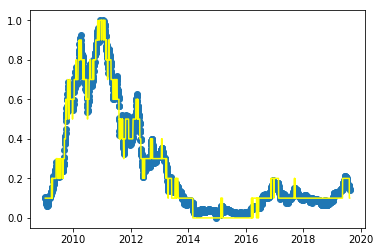

In [362]:
plt.plot(KS.index[:2662],X_trans[:2662],'o')
plt.plot(KS.index[:2662],y/10,'yellow')


In [345]:
# 다중 분류 10개


KS=fdr.DataReader("RSTI","2009-01-01","2019-08-14")
time=np.linspace(0,10,len(KS),endpoint=False).reshape(-1,1)

#특성 추가---
get_MA(KS)
get_stochastic(KS)
X=KS
#--------

# 10중 분류를 위한 종가 스케일 조정-------------------
X_Close=X["Close"].values.reshape(-1,1)
minMaxScaler = MinMaxScaler().fit(X_Close)
X_trans= minMaxScaler.transform(X_Close) 
y=pd.DataFrame(X_trans.round(1)*10,index=X.index)



#미래 예측을 위한 시간조정 -----------
y=y.shift(-1).dropna() 
X=X.loc[y.index]
#----------------------------


#전체 스케일 조정 ----------
minMaxScaler = MinMaxScaler().fit(X) 
X_scaler= minMaxScaler.transform(X)
X=pd.DataFrame(X_scaler,index=y.index,columns=X.columns)
#-----------------------------

X_train,X_test,y_train,y_test=X[:2000],X[2000:],y[:2000],y[2000:]

훈련 세트 정확도:0.889
테스트 세트 정확도:0.484
이웃-2


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


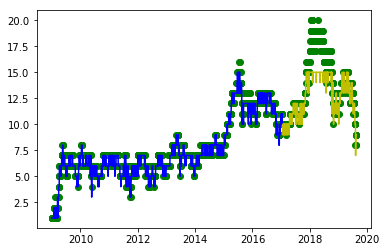

In [6]:
reg=neighbors.KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X_train.index,reg.predict(X_train),'b')
plt.plot(X_test.index,reg.predict(X_test),'y')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("이웃-2")

In [8]:
X_test.shape

(628, 6)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


훈련 세트 정확도:0.999
테스트 세트 정확도:0.741
랜덤 포레스트


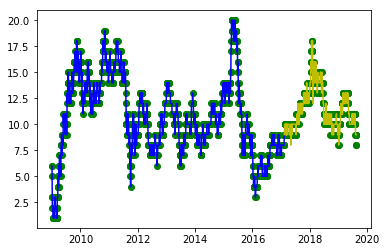

In [320]:
reg=RandomForestClassifier(n_estimators=50).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X_train.index,reg.predict(X_train),'b')
plt.plot(X_test.index,reg.predict(X_test),'y')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("랜덤 포레스트")

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


훈련 세트 정확도:0.744
테스트 세트 정확도:0.346
SVM


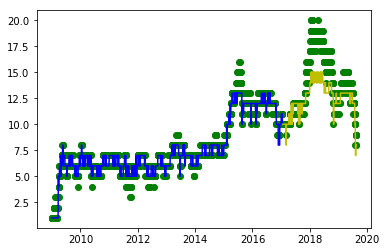

In [325]:
reg=svm.SVC(C=1000,gamma=0.001).fit(X_train,y_train)
plt.plot(X.index,y,'go')
plt.plot(X_train.index,reg.predict(X_train),'b')
plt.plot(X_test.index,reg.predict(X_test),'y')
print("훈련 세트 정확도:{:.3f}".format(reg.score(X_train,y_train)))
print("테스트 세트 정확도:{:.3f}".format(reg.score(X_test,y_test)))
print("SVM")

In [132]:
#그리드서치 간단모듈
from sklearn.model_selection import GridSearchCV

param_grid={'C':[10,100,1000],'gamma':[0.1,0.01,0.001]}
grid_search=GridSearchCV(svm.SVC(),param_grid,cv=5,return_train_score=True)
grid_search.fit(X_train,y_train)
grid_search.best_estimator_


C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d arr

C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\이승희\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d arr

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

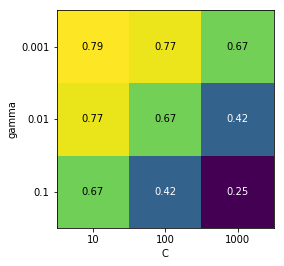

In [133]:
#히트맵
results=pd.DataFrame(grid_search.cv_results_)
scores=np.array(results.mean_test_score).reshape(3,3)
mglearn.tools.heatmap(scores,xlabel='C',xticklabels=param_grid['C'],ylabel='gamma',yticklabels=param_grid['gamma'])